<h1>Lateralized ERP's<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Condition-specific-ERPs-(step-by-step)" data-toc-modified-id="Condition-specific-ERPs-(step-by-step)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Condition specific ERPs (step by step)</a></span><ul class="toc-item"><li><span><a href="#select-data-of-interest" data-toc-modified-id="select-data-of-interest-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>select data of interest</a></span></li><li><span><a href="#determine-lateralization" data-toc-modified-id="determine-lateralization-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>determine lateralization</a></span></li><li><span><a href="#average-across-trials-and-electrodes" data-toc-modified-id="average-across-trials-and-electrodes-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>average across trials and electrodes</a></span></li><li><span><a href="#baseline-correction" data-toc-modified-id="baseline-correction-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>baseline correction</a></span></li><li><span><a href="#inspect-ERP" data-toc-modified-id="inspect-ERP-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>inspect ERP</a></span></li></ul></li><li><span><a href="#Condition-specific-ERPs-(DvM-toolbox)" data-toc-modified-id="Condition-specific-ERPs-(DvM-toolbox)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Condition specific ERPs (DvM toolbox)</a></span><ul class="toc-item"><li><span><a href="#Instantiate-ERP-object" data-toc-modified-id="Instantiate-ERP-object-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Instantiate ERP object</a></span></li><li><span><a href="#Flip-topography" data-toc-modified-id="Flip-topography-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Flip topography</a></span></li><li><span><a href="#Create-ipsi-and-contralateral-waveforms" data-toc-modified-id="Create-ipsi-and-contralateral-waveforms-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Create ipsi and contralateral waveforms</a></span></li><li><span><a href="#Inspect-the-result" data-toc-modified-id="Inspect-the-result-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Inspect the result</a></span></li><li><span><a href="#Extra-options" data-toc-modified-id="Extra-options-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Extra options</a></span></li></ul></li></ul></div>

This tutorial goes over how to create ERPs from preprocessed data. To be able to run this notebook, first you need to make sure that the example data is downloaded. The data can be downloaded [here](https://osf.io/j86zp/). To be able to read in the data make sure that both files are stored in the tutorial folder of the DvM toolbox in the following folders.

eeg data ('.fif'): .../tutorials/processed/ <br>
behavioral data ('.pickle'): .../tutorials/beh/processed


Once the data is saved, we start by importing the modules we need:

In [1]:
# import python packages
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import mne.filter

import matplotlib.pyplot as plt

# import DvM toolbox
sys.path.append('/Users/dvm/DvM') # point to local storage DvM toolbox
from support.FolderStructure import *
from eeg_analyses.ERP import * 

As a first step, we start by loading example data from 1 subject. This data is obtained in the following [paper](https://doi.org/10.1016/j.cortex.2021.01.010) and the raw data from all subjects can be downloaded [here](https://osf.io/n35xa/). The paradigm is shown below. In short, participants came to the lab twice, to perform a mixed-features and a fixed-features variant of the additional singleton paradigm (Theeuwes, 1992). Halfway, each experimental session, a high probability distractor location was introduced. As always all relevant experimental variables are stored in a seperate behavioral file that will be read in alongside the eeg data:

<img src="erp_design.png" style="width:600px;height=300px"/>

In [2]:
# read in data 
sj = 'erp'
beh, eeg = FolderStructure().loadData(sj = sj)
eeg.baseline = None # reset baseling procedure used during preprocessing

Reading /Users/dvm/DvM/tutorials/processed/subject-erp_all-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    1099.61 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1771 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


### Condition specific ERPs (step by step)

Now that we have read in the data, it is time to create an ERP (i.e., a stereotyped electrophysiological response to a stimulus). Here we are going to examine whether targets (i.e., the unique shape in the display) elicit an [N2pc](https://en.wikipedia.org/wiki/N2pc#:~:text=N2pc%20refers%20to%20an%20ERP,the%20brain%2C%20and%20vice%20versa.), which is a more pronounced negativity over posterior electrode sides contralateral than ipsilateral to the stimulus of interest. Before demonstrating how such a lateralized component can be obtained with the DvM toolbox, we are first going to go over the necessary steps ourselves.

####  select data of interest
   - For now we only take data from the blocks without a spatial bias into consideration (see trial design)
   - As this is lateralized component we need to make sure that we only select trials where the target was on the horizontal midline and the distractor was on the vertical midline or absent

In [3]:
# mask data of interest on the basis of behavioral parameters
mask = (beh.target_loc.isin([2,6])) & (beh.dist_loc.isin(['None', '0','4'])) & (beh.spatial_bias == 'no bias')
beh_ = beh[mask]
eeg_ = eeg[mask]

#### determine lateralization

In the preceding step we made sure that we only selected trials with distractors either being absent (label = 'None') or present on the vertical midline (label = '0' or '4'). Also we only selected lateralized targets. That is we only selected trials where the target was presented right (label = 6) or left (label = 2) from fixation. Next, we need to select the data such that we can create an ipsilateral (i.e.,electrodes belonging to the same hemifield as displayed stimulus) and a contralateral waveform (i.e.,electrodes belonging to the opposite hemifield as displayed stimulus).

- As electrode pairs of interest, we select P7/P8 and PO7/PO8 (i.e., typical N2pc electrodes)


In [4]:
# get electrodes of interest
left_elec, right_elec = ['P7','PO7'], ['P8','PO8']
left_elec_idx = [eeg.ch_names.index(elec) for elec in left_elec]
right_elec_idx = [eeg.ch_names.index(elec) for elec in right_elec]

# split trials with targets left and right from fixation
left_mask = beh_.target_loc == 2
right_mask = beh_.target_loc == 6

# based on left and right trials create contra and ipsi waveforms
contra = np.vstack((eeg_._data[left_mask][:, right_elec_idx], eeg_._data[right_mask][:, left_elec_idx]))
ipsi = np.vstack((eeg_._data[left_mask][:, left_elec_idx], eeg_._data[right_mask][:, right_elec_idx]))

#### average across trials and electrodes

The underlying assumption of ERP analysis is that by averaging many trials together, random brain activity will be averaged out, and hence the relevant waveform remains. The contralateral and the ipsilateral waveforms created in the cell above still contain all individual trials. Thus, to create the ERP we need to average across trials (i.e., the first dimension in the arrays; epochs X electrodes X times). Also, since we are interested in the average response at the electrodes of interest, we need to average across electrodes (i.e., the second dimension in the array)

In [5]:
# average across trials and electrodes
contra = contra.mean(axis = (0,1))
ipsi = ipsi.mean(axis = (0,1))

#### baseline correction

Almost there now. However, before we can inspect the resulting waveforms we need to apply a baseline correction. As EEG is a time-resolving signal, it often contains temporal drifts which are unrelated to our experimental question. Various internal and external sources may cause temporal drifts, which can change over time and electrodes. To reduce the effect of such drifts, it is custom to perform a so-called baseline correction. Essentially, this consists of using EEG activity over a baseline period (i.e., in our case the onset of the search display), to correct activity over a post-stimulus interval (i.e., in out case visual search itself). Although various approaches exist for baseline correction, the most common method in ERP research is subtracting the mean of a baseline period from every time point of the baseline and post-stimulus interval. In other words, the average voltage values of each electrode are calculated within a time interval and then this average is substracted from that time interval of the signal.

As explained [here](https://erpinfo.org/order-of-steps), baseline correction is a linear operation.  This means that you can perform baseline correction before or after averaging all trials together, and the result will be identical. 

In our example, onset of the search is at time point 0 and we will baseline correct over a (-200-ms,0-ms) prestimulus window.

In [6]:
# get indices of baseline window
base_time = (-0.2,0)
base_idx = slice(*[np.argmin(abs(eeg.times - t)) + i for t,i in zip(base_time, (0,1))]) # control for slice stop at end - 1

# perform baseline correction
contra -= contra[base_idx].mean()
ipsi -= ipsi[base_idx].mean()

#### inspect ERP

To inspect the resulting ERP, we inspect both the contralateral and ipsilateral waveforms as well as the difference waveform that results from subtracting the ipsilateral waveform from the contralateral waveform. A common step at this point is to filter out the high frequency noise that is present in the resulting waveforms. In the cell below we will first apply a 30-Hz low pass filter and then plot only the relevant window of interest. Note, that the data actually contain more timepoint than we are actually interested in, so that data can be 'safely' filtered without worrying too much at [filter artefacts](https://mne.tools/stable/auto_tutorials/discussions/plot_background_filtering.html) near the edges. 

Run the cells below, to see whether the resulting waveform is as expected? Also, play around with some different settings to see how the end result changes. For example, what are the characteristics of the waveform when it is tuned to the distractor instead of the target location. Inspect the [paper](https://doi.org/10.1016/j.cortex.2021.01.010) for the observed pattern across conditions.

In [7]:
# apply a 30-Hz low pass filter to the data 
contra = mne.filter.filter_data(contra, sfreq = 512, l_freq = None, h_freq = 30)
ipsi = mne.filter.filter_data(ipsi, sfreq = 512, l_freq = None, h_freq = 30)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



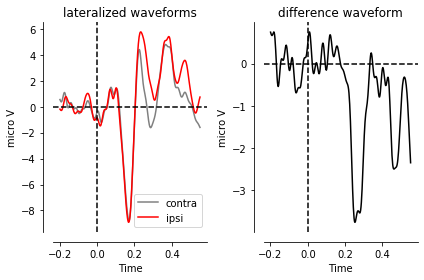

In [8]:
# set up plotting parameters
times_oi = (-0.2, 0.55)
times_oi_idx = slice(*[np.argmin(abs(eeg.times - t)) + i for t,i in zip(times_oi, (0,1))])

# plot contralateral and ipsilateral waveforms
ax = plt.subplot(1,2,1, xlabel = 'Time', ylabel = 'micro V', title = 'lateralized waveforms')
plt.plot(eeg.times[times_oi_idx], contra[times_oi_idx], label = 'contra', color = 'grey')
plt.plot(eeg.times[times_oi_idx], ipsi[times_oi_idx], label = 'ipsi', color = 'red')
plt.axvline(0, ls = '--', color = 'black')
plt.axhline(0, ls = '--', color = 'black')
plt.legend(loc = 'best')
sns.despine(offset = 10)

# plot difference waveform
ax = plt.subplot(1,2,2, xlabel = 'Time', ylabel = 'micro V', title = 'difference waveform')
diff = contra - ipsi
plt.plot(eeg.times[times_oi_idx], diff[times_oi_idx], color = 'black')
plt.axvline(0, ls = '--', color = 'black')
plt.axhline(0, ls = '--', color = 'black')
sns.despine(offset = 10)

plt.tight_layout()

### Condition specific ERPs (DvM toolbox)

In the above, we have created a target tuned difference waveform in four individual steps (1. select data, 2. determine lateralization, 3. averaging, 4. baseline correction). The cell below demonstrates how these steps can be easily combined by the ERP class in the DvM toolbox using a few lines of code. 

#### Instantiate ERP object

To be able to calculate ERPs, as a first step we need to instantiate the ERP class. Apart from the data (i.e., eeg and behavioral data) we need to pass at least two arguments, namely header and baseline. Header should be a string that refers to the column key in the beh dataframe, where information about the stimulus of interest is defined (i.e., in the example case, the column with target locations). Baseline is a tuple specifying the baseline window that will be used in the analysis.

In [9]:
# to make use of the ERP class, first instantiate a ERP object
erp = ERP(eeg, beh, header = 'target_loc', baseline = (-0.2,0))

#### Flip topography

In step 2 of the step by step ERP creation, we determined lateralization by specifying left and right electrodes. Within the ERP class, lateralization is handled by flipping the data from one hemifield to the other hemifield for all trials where the stimuli of interest was presented left from fixation. In other words, when calculating the ERPs it is assumed that all stimuli were presented right from fixation.

To flip the data, we first specify the window of interest, and apply a low pass filter (optional), so that filtering is applied before slicing the relevant time points. 

In [10]:
erp.selectERPData(time = [-0.2, 0.55], h_filter = 30)
erp.topoFlip(left = [2], header = 'target_loc')

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



#### Create ipsi and contralateral waveforms

Now everything is set up such, that we can create our ERPs using the ipsiContra function. This function has various options, which can be inspected below. For now, we ignore several of these options, and only try to mimic the waveform calculated in our step by step process. 

In [11]:
# inspect ipsiContra docstring
erp.ipsiContra?

Remember, the relevant settings that we used before, were the following.

- only include data from no spatial bias blocks
- only include lateralized targets (labels = 2 (left) and 6 (right)
- only include include trials with a distractor on the midline, or no distractor

In [12]:
# calculate ERP
erp.ipsiContra(sj = sj, left = [2], right = [6], l_elec = ['P7','PO7'], 
               r_elec = ['P8','PO8'], midline = {'dist_loc': ['0','4','None']},
               conditions = ['no bias'], cnd_header = 'spatial_bias',
               erp_name = 'target_N2pc', )

It is assumed as if all stimuli are presented right
Applying baseline correction (mode: mean)


#### Inspect the result

At this point, you may be surprised to find no clear output. This is because, for each call of the ipsiContra function an output file will be created with the relevant info specified in the function call. The cell below shows how this data, which is stored as an [mne evoked object](https://mne.tools/stable/generated/mne.Evoked.html), can be read in. It is beyond the scope of this tutorial to show all plotting options that are implemented by mne. Here we focus on how to use the evoked object to plot the difference waveform (and compare the result to step by step end result). 

In [13]:
# read in evoked object
erp = mne.Evoked(FolderStructure().FolderTracker(['erp','target_loc'], 'sj_erp-target_N2pc-no bias-ave.fif'))

    Found the data of interest:
        t =    -199.22 ...     550.78 ms (0.11 * 20 + 0.12 * 40 + 0.05 * 21 + 0.06 * 23 + 0.07 * 41 + 0.05 * 43 + 0.14 * 120 + 0.13 * 140 + 0.07 * 121 + 0.07 * 123 + 0.07 * 141 + 0.07 * 143)
        0 CTF compensation matrices available
        nave = 346 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.


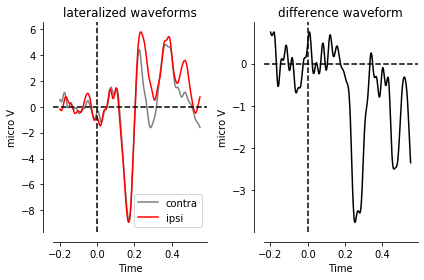

In [14]:
# specify ipsi and contralateral waveforms
contra_elec, ipsi_elec = ['P7','PO7'], ['P8','PO8']
contra_elec_idx = [eeg.ch_names.index(elec) for elec in contra_elec]
ipsi_elec_idx = [eeg.ch_names.index(elec) for elec in ipsi_elec]

# extract ipsi and contralateral data
contra = erp._data[contra_elec_idx].mean(axis = 0)
ipsi = erp._data[ipsi_elec_idx].mean(axis = 0)

# plot contralateral and ipsilateral waveforms
ax = plt.subplot(1,2,1, xlabel = 'Time', ylabel = 'micro V', title = 'lateralized waveforms')
plt.plot(erp.times, contra, label = 'contra', color = 'grey')
plt.plot(erp.times, ipsi, label = 'ipsi', color = 'red')
plt.axvline(0, ls = '--', color = 'black')
plt.axhline(0, ls = '--', color = 'black')
plt.legend(loc = 'best')
sns.despine(offset = 10)

# plot difference waveform
ax = plt.subplot(1,2,2, xlabel = 'Time', ylabel = 'micro V', title = 'difference waveform')
diff = contra - ipsi
plt.plot(erp.times, diff, color = 'black')
plt.axvline(0, ls = '--', color = 'black')
plt.axhline(0, ls = '--', color = 'black')
sns.despine(offset = 10)

plt.tight_layout()

#### Extra options

The ERP class offers several extra options. For example the snippet of code below, shows how to calculate ERPs tuned to the distractor, seperately for spatial and no spatial bias blocks, using only correct responses and split by response time (i.e., fast vs. slow responses).

In [15]:
# read in data 
beh, eeg = FolderStructure().loadData(sj = sj)
eeg.baseline = None # reset baseling procedure used during preprocessing

# instantiate a ERP object
erp = ERP(eeg, beh, header = 'dist_loc', baseline = (-0.2,0))

# flip topography
erp.selectERPData(time = [-0.2, 0.55], h_filter = 30, excl_factor = dict(correct = [0]))
erp.topoFlip(left = ['2'], header = 'dist_loc')

# calculate ERP
erp.ipsiContra(sj = sj, left = ['2'], right = ['6'], l_elec = ['P7','PO7'], 
               r_elec = ['P8','PO8'], midline = {'target_loc': [0,4]},
               conditions = ['no bias','bias'], cnd_header = 'spatial_bias',
               erp_name = 'dist_tuned', RT_split = True)

Reading /Users/dvm/DvM/tutorials/processed/subject-erp_all-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    1099.61 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1771 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Dropped 177 epochs: 5, 6, 11, 14, 15, 20, 29, 32, 33, 34, 41, 43, 44, 50, 53, 55, 57, 60, 62, 64, 66, 68, 70, 77, 78, 79, 80, 81, 99, 102, 116, 126, 128, 132, 134, 139, 142, 149, 156, 159, 161, 173, 175, 181, 182, 190, 192, 195, 199, 201, 204, 215, 234, 244, 245, 246, 247, 263, 275, 280, 282, 295, 316, 321, 324, 336, 340, 350, 351, 353, 360, 365, 378, 383, 384, 398, 403, 414, 436, 454, 458, 469, 470, 483, 484, 497, 502, 503, 508, 513, 537, 539, 552, 561, 562, 621, 628, 632, 651, 654, 663, 669, 671, 698, 701, 711, 714, 720, 727, 743, 745, 746, 765, 787, 798, 800, 808, 812, 813, 814, 815, 821, 824, 829, 833, 837, 850, 851, 854, 855, 857, 858, 859, 862, 863, 866, 8